**Footnote:**

For this Milestone, we didn’t have the final results because the NN was still being trained. Therefore, we tried to answer the questions that we could without having the results. As you can see, we mainly focus on the preprocessing stage.

If you have time, we would like to have a proper feedback session with the results once they are ready.

We take full responsabilitty on not being able to show the results on time. Anyways, we will like to express that this is the Milestone that we have worked the most, and it was just a matter of computational time that we couldn't deliver the results on time.

# **Milestone 4**

In this project we want to build a RNN music generation model that is able to compose novel music in relation to other instrument notations. Our aim is to then be able to test this model using different genres of music (determined by metadata) to observe if certain genres are more learnable or have more simple relationships between the different instruments.

In a broader way, we want to test if there exists enough information in MIDI-files to capture the genre of a specific song. Most MIR is done on Audio rather than midi-files and there has been a discussion whether the FoM (figure of merit) of common MIR systems comes from the system using characteristics confounded with the “ground truth” of the dataset. This would imply these MIR systems are not addressing the musical problem for which it was designed. Using a generative approach that rely only on MIDI information, plenty of the irrelevant transformations could be avoided and the system would be more designed to solve a musical problem.


# **Data preprocessing**
For this project, we are using the dataset that is provided by Colin Raffel under CC-BY 4.0 license which was created by him for his PhD Thesis: "Learning-Based Methods for Comparing Sequences, with Applications to Audio-to-MIDI Alignment and Matching". The dataset, either in full amount or subsets can be accessed here: https://colinraffel.com/projects/lmd/ 

The dataset used have 45 000 deduped MIDI files that have been matched to entries in the Million Song Dataset. On this dataset we also have matched metadata on every entry, where we use the genre tags associated to every song. The tags comes are comes from the echo-nest lab and are available here: http://millionsongdataset.com/pages/get-all-artists-and-their-tags/. 

The tags are based on the artist rahter the being unique for each song. This poses the following problem: If an artist have created several songs associated to different genres, the list of all of those genes are stored in the tags of every song by that artist. The more times an artist have create a song within a particular genre, the more times that genre is present in the list of genres. In order to have the songs in our dataset to be tagged by appropriate genres, we have to eliminate some of the genres in the metadata. This elimination is done by first counting how many times each genre appears in the list of genres. Then the number of times a genre is present in the list of genres are divided by the number of times the genre whom are most frequent in the list of genres is present in the list of genres. This way most of the songs were only tagged by very few genres, normally in the range 1 to 4 tags. 

The next step of the preprocessing was to see how many songs of each genre are present in our dataset.

As we are using the data to train a artificial neural network, this made us considering merging genres that similar (to be able to have enough data for the NN to generalize properly). In order to determine which genres are similar we consulted ourselves and also relied on correlation metric verify that our assumptions are in alignment with the data available. Further in the code, the jaccard correlation of the most prevalent genres in the dataset is presented and also the pearson correlation of the most prevalent genres is presented. We chose to merge Progressive house, hard house, deep house, Trance and hard trance as they are very similar in our opinion. Moreover they are very correlated, which indicates that our assumption that these genres are close to each other is true. Also, as you may see in a further plot, there's overlapping in the 3 genres selected. Even though this may be seemed as a problem, we kept it that way because it represents a more "real" approach, were a song is not exclusively part of one specific genre, but maybe more than one at the same time.

The next step of the preprocessing was the instrument part. Here we had the problem that the distribution of instruments was really sparse among the available MIDI files. Because of that, we decided to do a instrument merging, that means, merging several instruments that belong to the “same family” or that they play the same “roles” in the songs. For this, we decided to work with 4 instrument families: drums, basses, guitars and pianos. The drums were easily spotted, since they are already differentiated in a midi file as a “drum instrument” (basically, with no pitch differentiation among their notes). Then, we did a instrument hierarchical clustering (using pitch distributions) and found out that the bass family was really a defined group (they did not merge with other cluster until the final iterations of the algorithms). The only problem we found is that the guitars and pianos have mainly the same pitch distribution. Nevertheless, we decided to keep them separately for the model to be able to generate future songs with those tracks being apart (otherwise, it will sound really “noisy”).

With that being said, the preprocessing pipeline worked like this:
1. We selected all the songs from each of the 3 genres selected.
2. For each song, we found all their MIDI files associated (one song could have had more than one MIDI file, in average, each song has 4 MIDI representations)
3. Having all the MIDI files for each genre, we modified the midi content to fit all the instruments notes on each of the 4 families (according to our instruments mapping). All the MIDI files that didn’t have an instruments on any of the 4 families, was filtered out.
4. With the MIDI files pre processed, we translated the MIDI information to a specific encoding (for each instrument family track). The encoding used was …

After this, the data was ready to feed the model.


**Genres part:**

In [0]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
import librosa
import mir_eval
import mir_eval.display
import tables
import IPython.display
import os
import json
import hdf5_getters as getters
import pandas as pd
from scipy.stats import pearsonr
from collections import Counter

# Local path constants
DATA_PATH = 'data'
RESULTS_PATH = 'Data'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')
TAGS_FILE = os.path.join(RESULTS_PATH, 'unique_tracks.txt')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

def msd_id_to_h5(h5):
    """Given an MSD ID, return the path to the corresponding h5"""
    return os.path.join(RESULTS_PATH, 'lmd_matched_h5',
                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(RESULTS_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

In [0]:
with open(SCORE_FILE) as f:
    scores = json.load(f)
  
# ------- If we want more metadata -------
#meta_tags = pd.read_csv(TAGS_FILE, names=["msd_id", "song_id", "artist_name", "song_title"], sep = '<SEP>')
#meta_tags = meta_tags.set_index('msd_id').T.to_dict('list')

In [0]:
def get_most_helper(msd_id,n):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms)[:n]
    
def get_all(msd_id):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms)
    
def get_info(msd_id):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms_weight)

def get_most_common(m_id,n):
    msd_id = m_id
    temp_list = []
    l = get_most_helper(msd_id,n)
    for i in l:
        #print(i.decode('UTF-8'))
        temp_list.append(i.decode('UTF-8'))
    return  temp_list

def add_to_genres_to_msd(dictionary, m_id, n):
    dictionary[m_id] = get_most_common(m_id,n)
    
def add_msd_to_genres(dictionary, m_id, n):
    msd_id = m_id
    temp_list = get_most_common(msd_id,n)
    for i in temp_list:
        # Check if it is in the dict before otherwise add it
        if i in dictionary:
            dictionary[i].append(m_id)
        else:
            dictionary[i] = [m_id]
    return

# Have to do outside!
def get_all_genres(n):
    d = {}
    scores_list = list(scores.keys())
    end_i = len(scores_list)-1
    #end_i = len(list(scores.keys()))-1
    for i in range(0,10):
        msd_id = scores_list[i]
        print(msd_id)
        #add_msd_to_genres(d,msd_id,n)
        temp_list = get_most_common(msd_id,n)
        print(get_most_common(msd_id,n))
        d[msd_id] = temp_list
        del(temp_list,msd_id)
    return d

def get_specific_genres(l,n):
    return

def get_genre_dist(d):
    temp_d = d.copy()
    for k in d.keys():
        temp_d[k] = len(d[k])
    temp_list = list(d.values())
    lat_list = [item for sublist in temp_list for item in sublist]
    den = len(list(set(lat_list)))
    a = temp_d.copy()
    #return {k: v / total for total in (sum(a.values()),) for k, v in a.items()}
    return {k: v / den for k, v in a.items()}


In [0]:
with open(SCORE_FILE) as f:
    tags = json.load(f)

In [0]:
# For some reason we cant put this as a function, then it doesn't work. Really weird
d = {}
end_i = len(list(scores.keys()))-1
for i in range(0,end_i):
    msd_id = list(scores.keys())[i]
    a = get_info(msd_id)
    n = len([i for i in a if i >= 0.90])
    add_msd_to_genres(d,msd_id,n)

In [0]:
dist = get_genre_dist(d)
distribution_sorted = {k: v for k, v in sorted(dist.items(), key=lambda item: item[1],reverse = True)}

In [0]:
def get_dict_over_percentage(d,p):
    return {k:v for k, v in d.items() if v > p}


top_distribution = get_dict_over_percentage(distribution_sorted,0.025)

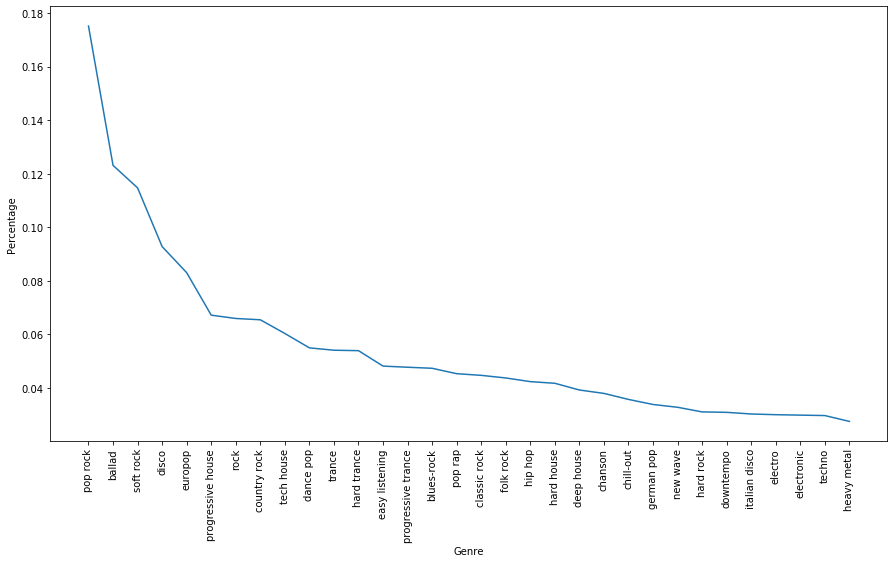

In [0]:
lists = top_distribution.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize = (15,8))
plt.plot(x, y)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Percentage')
plt.show()


In [0]:
country_rock_corpus = d['country rock']
hip_hop_corpus = d['hip hop']
disco_corpus = d['disco']


print('Length of: "country rock corpus" is ' + str(len(country_rock_corpus)) + ' songs')
print('Length of: "hip hop corpus" is ' + str(len(hip_hop_corpus)) + ' songs')
print('Length of: "disco corpus" is ' + str(len(disco_corpus)) + ' songs')


Length of: "country rock corpus" is 2010 songs
Length of: "hip hop corpus" is 1301 songs
Length of: "disco corpus" is 2849 songs


In [0]:
temp_list = list(d.values())
lat_list = [item for sublist in temp_list for item in sublist]
den = len(list(set(lat_list)))

dict_songs = {k: int(v * den,) for k, v in top_distribution.items()}

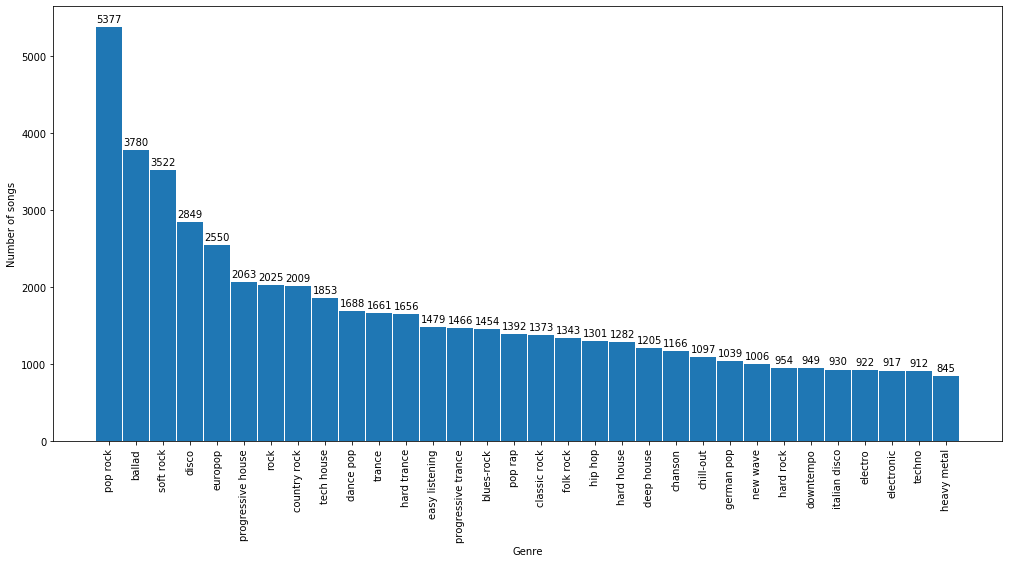

In [0]:
lists = dict_songs.items() # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

fig, ax = plt.subplots(figsize = (17,8))

width = 0.95

rects = ax.bar(x, y,width)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects)
plt.xticks(rotation=90)
plt.xlabel('Genre')
plt.ylabel('Number of songs')
plt.show()



In [0]:
top_keys = list(top_distribution.keys())
top_keys 

['pop rock',
 'ballad',
 'soft rock',
 'disco',
 'europop',
 'progressive house',
 'rock',
 'country rock',
 'tech house',
 'dance pop',
 'trance',
 'hard trance',
 'easy listening',
 'progressive trance',
 'blues-rock',
 'pop rap',
 'classic rock',
 'folk rock',
 'hip hop',
 'hard house',
 'deep house',
 'chanson',
 'chill-out',
 'german pop',
 'new wave',
 'hard rock',
 'downtempo',
 'italian disco',
 'electro',
 'electronic',
 'techno',
 'heavy metal']

In [0]:
# Functions for correlation metrics
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


def get_column_jaccard(d,gen,top_keys):
    list_of_songs1 = d[gen]
    scores = []
    for i in top_keys:
        score = jaccard_similarity(d[gen], d[i])
        scores.append(score)
    return scores

def get_column_pearson(d,gen,top_keys):
    l = list(d.values())
    flatten = [item for sublist in l for item in sublist]
    s = list(set(flatten))  
    
    sparse_array_gen = get_row_values(s,d[gen])
    scores = []
    for i in top_keys:
        sparse_array_2 = get_row_values(s,d[i])
        score = pearsonr(sparse_array_gen, sparse_array_2)[0]
        scores.append(score)
    return scores

def get_row_values(s,l):
    a = np.empty(len(s), dtype=int) 
    for i in range(0,len(s)):
        there = 0
        if s[i] in l:
            there = 1
        a[i] = there
    return a
 
def get_corr_df(d, columns, method='jaccard'):
    df = pd.DataFrame(0, index=columns , columns=columns)
    for k in columns:
        col_vals = []
        if method is 'jaccard':
            col_vals = get_column_jaccard(d,k,columns)
            df[k] = col_vals
        if method is 'pearson':
            col_vals = get_column_pearson(d,k,columns)
            df[k] = col_vals
    return df 




In [0]:
## WARNIGN LONG RUNTIME ~ 20 min, set a = True to run
a = False
df_jaccard_correlation = get_corr_df(d, top_keys)
if a is True:
    df_pearson_correlation = get_corr_df(d, top_keys,method='pearson')

In [0]:
df_jaccard_correlation

,pop rock,ballad,soft rock,disco,europop,progressive house,rock,country rock,tech house,dance pop,...,chill-out,german pop,new wave,hard rock,downtempo,italian disco,electro,electronic,techno,heavy metal
pop rock,1.000000,0.286818,0.351405,0.153879,0.176986,0.032186,0.076028,0.105673,0.021908,0.036684,...,0.021780,0.068621,0.070064,0.064391,0.043894,0.067536,0.015640,0.051453,0.012070,0.021843
ballad,0.286818,1.000000,0.269471,0.204397,0.254459,0.040235,0.037348,0.106863,0.021767,0.040335,...,0.029555,0.126724,0.029684,0.013704,0.065810,0.083506,0.012925,0.049140,0.012079,0.002601
soft rock,0.351405,0.269471,1.000000,0.126813,0.121951,0.016379,0.057780,0.143684,0.006177,0.025792,...,0.025761,0.064908,0.031193,0.017735,0.027580,0.044335,0.005202,0.020225,0.006127,0.005758
disco,0.153879,0.204397,0.126813,1.000000,0.218186,0.081462,0.024595,0.051277,0.078440,0.074609,...,0.025201,0.087552,0.055860,0.005819,0.096420,0.147934,0.065856,0.127545,0.030693,0.003532
europop,0.176986,0.254459,0.121951,0.218186,1.000000,0.114520,0.024407,0.028881,0.082350,0.065359,...,0.025591,0.130394,0.044334,0.014476,0.075623,0.158841,0.030267,0.130421,0.041203,0.004141
progressive house,0.032186,0.040235,0.016379,0.081462,0.114520,1.000000,0.007145,0.002215,0.355956,0.030211,...,0.050532,0.006163,0.010533,0.001328,0.088937,0.046138,0.128118,0.162700,0.114650,0.001033
rock,0.076028,0.037348,0.057780,0.024595,0.024407,0.007145,1.000000,0.042905,0.011740,0.005416,...,0.015615,0.015578,0.074035,0.094416,0.011565,0.014070,0.019723,0.016586,0.005478,0.049360
country rock,0.105673,0.106863,0.143684,0.051277,0.028881,0.002215,0.042905,1.000000,0.006514,0.002983,...,0.008439,0.051742,0.009030,0.021717,0.006463,0.003756,0.007906,0.000684,0.005160,0.000350
tech house,0.021908,0.021767,0.006177,0.078440,0.082350,0.355956,0.011740,0.006514,1.000000,0.016069,...,0.041667,0.007315,0.014544,0.007538,0.084785,0.050189,0.188946,0.149855,0.211656,0.004468
dance pop,0.036684,0.040335,0.025792,0.074609,0.065359,0.030211,0.005416,0.002983,0.016069,1.000000,...,0.015312,0.010749,0.077569,0.008397,0.031690,0.044693,0.017147,0.031683,0.009317,0.000000


In [0]:
df_pearson_correlation

,pop rock,ballad,soft rock,disco,europop,progressive house,rock,country rock,tech house,dance pop,...,chill-out,german pop,new wave,hard rock,downtempo,italian disco,electro,electronic,techno,heavy metal
pop rock,1.000000,0.359670,0.456397,0.176652,0.231484,-0.044238,0.058143,0.122654,-0.060983,-0.017136,...,-0.024972,0.109030,0.116272,0.106650,0.049425,0.118075,-0.032359,0.074218,-0.042751,-0.007839
ballad,0.359670,1.000000,0.347277,0.264533,0.348457,-0.011068,-0.016085,0.124864,-0.044998,0.001830,...,0.002649,0.227013,0.007814,-0.030528,0.100333,0.143739,-0.031072,0.062379,-0.032853,-0.055755
soft rock,0.456397,0.347277,1.000000,0.137460,0.136113,-0.059856,0.029128,0.191915,-0.077052,-0.028073,...,-0.005409,0.089776,0.012337,-0.018508,0.006586,0.049098,-0.049555,-0.010314,-0.046719,-0.044930
disco,0.176652,0.264533,0.137460,1.000000,0.297112,0.080079,-0.032057,0.022924,0.080172,0.078003,...,-0.002891,0.134470,0.069689,-0.043031,0.159526,0.262464,0.096988,0.224828,0.018107,-0.044875
europop,0.231484,0.348457,0.136113,0.297112,1.000000,0.142690,-0.028132,-0.018569,0.089764,0.062042,...,-0.000062,0.213906,0.044646,-0.019877,0.114013,0.275298,0.017589,0.224542,0.042591,-0.040523
progressive house,-0.044238,-0.011068,-0.059856,0.080079,0.142690,1.000000,-0.056108,-0.066292,0.493586,-0.001944,...,0.054879,-0.036552,-0.026042,-0.045056,0.136989,0.052771,0.211191,0.271619,0.187537,-0.042759
rock,0.058143,-0.016085,0.029128,-0.032057,-0.028132,-0.056108,1.000000,0.017745,-0.042539,-0.052571,...,-0.017209,-0.015616,0.105057,0.146784,-0.021671,-0.015566,-0.002923,-0.009615,-0.034120,0.063588
country rock,0.122654,0.124864,0.191915,0.022924,-0.018569,-0.066292,0.017745,1.000000,-0.053244,-0.057475,...,-0.032496,0.059708,-0.028771,0.000420,-0.032806,-0.038320,-0.028818,-0.044886,-0.034668,-0.043714
tech house,-0.060983,-0.044998,-0.077052,0.080172,0.089764,0.493586,-0.042539,-0.053244,1.000000,-0.027518,...,0.038170,-0.031540,-0.015179,-0.028825,0.127809,0.061352,0.308817,0.245596,0.344776,-0.032597
dance pop,-0.017136,0.001830,-0.028073,0.078003,0.062042,-0.001944,-0.052571,-0.057475,-0.027518,1.000000,...,-0.014090,-0.022218,0.111229,-0.025070,0.023804,0.050755,-0.005596,0.024840,-0.021996,-0.040571


In [0]:
df_jaccard_correlation['hard rock']

pop rock              0.064391
ballad                0.013704
soft rock             0.017735
disco                 0.005819
europop               0.014476
progressive house     0.001328
rock                  0.094416
country rock          0.021717
tech house            0.007538
dance pop             0.008397
trance                0.001916
hard trance           0.001535
easy listening        0.008288
progressive trance    0.001241
blues-rock            0.064545
pop rap               0.011207
classic rock          0.106515
folk rock             0.013233
hip hop               0.009400
hard house            0.001343
deep house            0.023708
chanson               0.003788
chill-out             0.004407
german pop            0.017356
new wave              0.031020
hard rock             1.000000
downtempo             0.001579
italian disco         0.001595
electro               0.002672
electronic            0.002680
techno                0.002687
heavy metal           0.316020
Name: ha

In [0]:
df_jaccard_correlation.to_csv(r'/Users/axelsjoberg/Desktop/Digital Musicology/Project/jaccard.csv',index=False) 

In [0]:
genre_instruments = {k[7:-1].split("/", 1)[0]: v for k, v in instruments.items()}
#list(genre_instruments.keys())
#genre_instruments

In [0]:
def add_instrumnets_to_genre(d,m_id,instruments,n):
    temp_list = get_most_common(m_id,n)
    for i in temp_list:
        # Check if it is in the dict before otherwise add it
        if i in d:
            d[i].append(instruments)
        else:
            d[i] = [instruments]
    return

def instrument_counts(d):
    instrument_counts = {}
    keys = list(d.keys())
    for k in keys:
        l = list(d[k])
        #print(l)
        flat_list = [item for sublist in l for item in sublist]
        counts = Counter(flat_list)
        counts2 = {k: np.round(v/len(l),3) for k, v in counts.items()}
        instrument_counts[k] = counts2
    return instrument_counts

def plot_instruments_in_genre(genre, d):
    d_g = d[genre]
    plt.bar(d_g.keys(), d_g.values())
    plt.title(genre)
    #autolabel(rects)
    plt.xticks(rotation=90)
    plt.xlabel('instrument')
    plt.ylabel('Probability the instrument is in the genre')

    
genre_instruments = {k[7:-1].split("/", 1)[0]: v for k, v in instruments.items()}
#list(genre_instruments.keys())
#genre_instruments    


def get_info(msd_id):
    to_h5 = msd_id_to_h5(msd_id)
    with tables.open_file(to_h5) as h5:
        return list(h5.root.metadata.artist_terms_weight)
    
    
d_instruments = {}
song_ids= list(genre_instruments.keys())
for msd_id in song_ids:
    a = get_info(msd_id)
    n = len([i for i in a if i >= 0.90])
    instruments = genre_instruments[msd_id]
    add_instrumnets_to_genre(d_instruments,msd_id,instruments,n)

instrument_counts = instrument_counts(d_instruments)



In [0]:
with open('genres_dict_merged.json', 'w') as outfile:
    json.dump(merged_dict, outfile)

 
 ------------------------------- Instrument frequencies in different genres --------------------------------


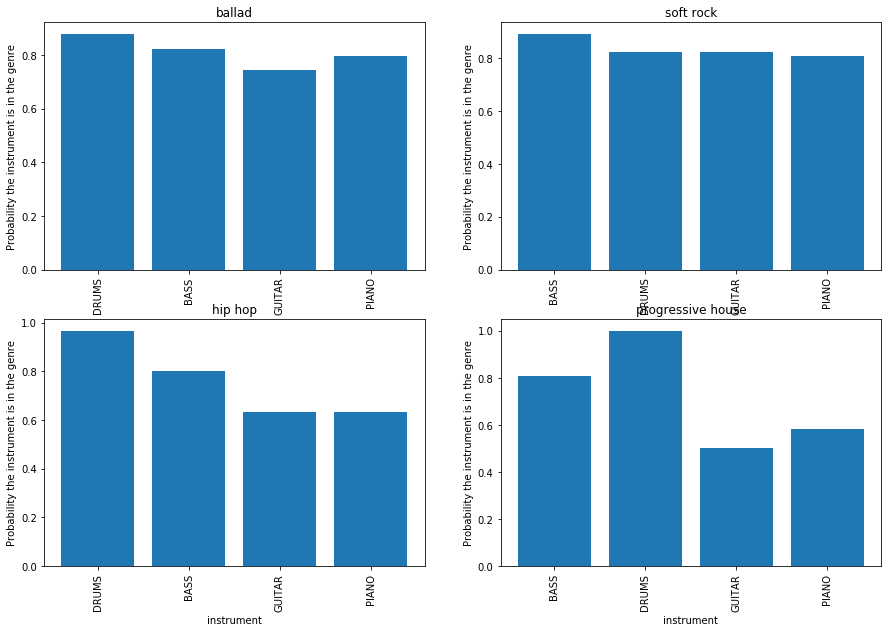

In [0]:
f, axs = plt.subplots(2,2,figsize=(15,10))
print(' \n ------------------------------- Instrument frequencies in different genres --------------------------------')

plt.subplot(2, 2, 1)
plot_instruments_in_genre('ballad', instrument_counts)

plt.subplot(2, 2, 2)
plot_instruments_in_genre('soft rock', instrument_counts)

plt.subplot(2, 2, 3)
plot_instruments_in_genre('hip hop', instrument_counts)

plt.subplot(2, 2, 4)
plot_instruments_in_genre('progressive house', instrument_counts)

#plt.show()


In [0]:
inv_map = {}
for k, v in merged_dict.items():
    #inv_map[v] = inv_map[v]
    for m_id in v:    
        if m_id in inv_map:
            inv_map[m_id].append(k)
        else:
            inv_map[m_id] = [k]
            
def inv_dict(d):
    inv_map = {}
    for k, v in merged_dict.items():
    #inv_map[v] = inv_map[v]
        for m_id in v:    
            if m_id in inv_map:
                inv_map[m_id].append(k)
            else:
                inv_map[m_id] = [k]
    return inv_map

In [0]:
with open('data.json') as json_file:
    dd = json.load(json_file)
    


In [0]:
with open('genre_msd_dict.json', 'w') as outfile:
    json.dump(genre_msd_dict, outfile)

In [0]:
with open('genre_msd_dict.json') as json_file:
    dd1 = json.load(json_file)

**Instruments part:**

In [0]:
import os
import tqdm
import pretty_midi
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import json
from random import sample
import pandas as pd
import IPython.display
from sklearn.cluster import KMeans, AgglomerativeClustering
import numpy as np
from time import time
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
data_path = 'gdrive/Shared drives/Digital Musicology 2020/data'
os.chdir(data_path)

In [0]:
#Aprox running time: 1 seg per song
#Geting some necessary info:
with open("all_midis_paths.txt", "r") as file:
  all_midi_paths = [line for line in file]
all_midi_dirs = set([midi_path[1:27] for midi_path in all_midi_paths])
with open("match_scores.json") as file:
    scores = json.load(file)

initial_time = time()
sample_size = int(len(all_midi_dirs)*0.5)
errors_count = 0
print(f"Sample size: {sample_size}")
instruments_info = {instrument_program: {pitch_number: 0 for pitch_number in range(128)} for instrument_program in range(128)}
#notes_count = {instrument_program: {pitch_number: 0 for pitch_number in range(128)} for instrument_program in range(128)}
instruments_count = {instrument_program: list() for instrument_program in range(128)}

for i, midi_dir in enumerate(sample(all_midi_dirs, sample_size)):
  if not i%100:
    print(i)
  midi_path = list(scores[midi_dir[7:25]].keys())[0]
  try:
    pm = pretty_midi.PrettyMIDI("lmd_aligned" + midi_dir + midi_path + ".mid")
    song_duration = pm.get_end_time()
    for instrument in pm.instruments:
      if not instrument.is_drum:
        for note in instrument.notes:
          note_duration = note.end - note.start
          instruments_info[instrument.program][note.pitch] += note_duration/song_duration
          #notes_count[instrument.program][note.pitch] += 1
        instruments_count[instrument.program].append(midi_dir + midi_path)
  except:
    errors_count += 1
end_time = time()
with open('instruments_info.json', 'w') as json_file:
  json.dump(instruments_info, json_file)
with open('instruments_count.json', 'w') as json_file:
  json.dump(instruments_count, json_file)
print(f"It took {end_time - initial_time} seconds to process {sample_size - errors_count} songs (avg of {(end_time - initial_time)/(sample_size - errors_count)} seconds/song)")
print(f"There were {errors_count} MIDI file(s) with errors")

Sample size: 15513
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
It took 10654.03278541565 seconds to process 15483 songs (avg of 0.6881116570054673 seconds/song)
There were 30 MIDI file(s) with errors


In [0]:
#Opening already procesed instruments info:
with open('instruments_info.json') as json_file:
  instruments_info = json.load(json_file)
with open('instruments_count.json') as json_file:
  instruments_count = json.load(json_file)
instruments_count = {int(key): value for key, value in instruments_count.items()}
instruments_info = {int(key): {int(inner_key): value for inner_key, value in dict_.items()} for key, dict_ in instruments_info.items()}

In [0]:
instruments_info_norm = {instrument_program: dict() for instrument_program in range(128)}
for inst in range(128):
  for note in range(128):
    #if notes_count[inst][note] > 0:
    if len(instruments_count[inst]) > 0:
      #instruments_info_norm[inst][note] = instruments_info[inst][note]/notes_count[inst][note]
      instruments_info_norm[inst][note] = instruments_info[inst][note]/len(instruments_count[inst])
    else:
      instruments_info_norm[inst][note] = instruments_info[inst][note]

Instrument: Alto Sax
Present in 1295 songs of the sample (8.35% of sample)


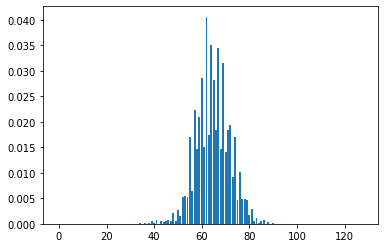

In [0]:
instrument_program = 65
print(f"Instrument: {pretty_midi.program_to_instrument_name(instrument_program)}")
print(f"Present in {len(set(instruments_count[instrument_program]))} songs of the sample ({round(100*len(set(instruments_count[instrument_program]))/15513, 2)}% of sample)")
plt.bar(instruments_info_norm[instrument_program].keys(), instruments_info_norm[instrument_program].values())
plt.show()

In [0]:
note_distributions_df = pd.DataFrame(columns=[pitch_number for pitch_number in range(128)])
for instrument_distr in instruments_info_norm.values():
  note_distributions_df = note_distributions_df.append(instrument_distr, ignore_index=True)
note_distributions_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000015,0.000051,0.000011,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,9.948256e-08,8.343698e-07,0.000000,0.000000,0.000030,0.000000,0.000003,0.000004,0.000000,0.000018,0.000006,0.000051,0.000045,0.000113,0.000240,0.000312,0.000561,0.000426,0.001959,0.001996,0.001228,0.004074,0.002887,0.005364,0.004635,0.004974,0.010750,0.004797,0.013377,0.006642,...,0.002610,0.001488,0.000910,0.001395,0.000466,0.000752,0.000308,0.000329,0.000520,0.000151,0.000279,0.000046,0.000135,0.000056,0.000018,0.000083,0.000004,0.000023,0.000002,0.000015,0.000023,0.000000,0.000002,0.000000,0.000001,6.391997e-07,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000005,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000062
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.000000,0.000000,0.000147,0.000066,0.000518,0.000335,0.000981,0.000627,0.001757,0.002310,0.000896,0.004962,0.002548,0.004391,0.004904,0.002804,0.013016,0.004970,0.014409,0.008471,...,0.002605,0.001155,0.000874,0.001333,0.000681,0.000829,0.000060,0.000320,0.000374,0.000062,0.000389,0.000045,0.000124,0.000034,0.000005,0.000011,0.000060,0.000084,0.000000,0.000006,0.000004,0.000067,0.000000,0.000109,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000013,0.000035,0.000047,0.000012,0.000037,0.0,3.162557e-07,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,0.000000,0.000080,0.000308,0.000000,0.000415,0.000086,0.001329,0.000888,0.000249,0.003657,0.000557,0.004860,0.001870,0.001405,0.008458,0.002694,0.006023,0.008515,...,0.002079,0.000795,0.000461,0.001207,0.000076,0.000729,0.000051,0.000534,0.001186,0.000048,0.000070,0.000033,0.000253,0.000003,0.000000,0.000003,0.000000,0.000003,0.000000,0.000003,0.000002,0.000000,0.000001,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.391341e-07,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000000,0.000934,0.000201,0.001420,0.001259,0.001238,0.000554,0.002375,0.007729,0.004430,0.001967,0.004894,0.005645,0.007253,0.002734,...,0.001149,0.001321,0.000393,0.000848,0.000226,0.000718,0.000671,0.000281,0.000233,0.000007,0.000083,0.000142,0.000004,0.000003,0.000085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000016,0.000016,0.000087,0.000000,0.000000,0.000047,0.000591,0.000476,0.001386,0.000300,0.000698,0.000635,0.000465,0.001544,0.001900,0.001944,0.001745,0.001637,0.006333,0.001561,0.010784,0.004926,...,0.001948,0.001161,0.000494,0.001165,0.000328,0.000466,0.000281,0.000014,0.000054,0.000000,0.000069,0.000007,0.000000,0.000081,0.000000,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [0]:
#Delete all zero columns
deleted_columns = [column for column in range(128) if len(set(note_distributions_df[column].to_list())) == 1]
note_distributions_df = note_distributions_df.drop(deleted_columns, axis=1)
note_distributions_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,0.000015,0.000051,0.000011,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,9.948256e-08,8.343698e-07,0.000000,0.000000,0.000030,0.000000,0.000003,0.000004,0.000000,0.000018,0.000006,0.000051,0.000045,0.000113,0.000240,0.000312,0.000561,0.000426,0.001959,0.001996,0.001228,0.004074,0.002887,0.005364,0.004635,0.004974,0.010750,0.004797,0.013377,0.006642,...,0.002610,0.001488,0.000910,0.001395,0.000466,0.000752,0.000308,0.000329,0.000520,0.000151,0.000279,0.000046,0.000135,0.000056,0.000018,0.000083,0.000004,0.000023,0.000002,0.000015,0.000023,0.000000,0.000002,0.000000,0.000001,6.391997e-07,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000005,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000062
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.000000,0.000000,0.000147,0.000066,0.000518,0.000335,0.000981,0.000627,0.001757,0.002310,0.000896,0.004962,0.002548,0.004391,0.004904,0.002804,0.013016,0.004970,0.014409,0.008471,...,0.002605,0.001155,0.000874,0.001333,0.000681,0.000829,0.000060,0.000320,0.000374,0.000062,0.000389,0.000045,0.000124,0.000034,0.000005,0.000011,0.000060,0.000084,0.000000,0.000006,0.000004,0.000067,0.000000,0.000109,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000013,0.000035,0.000047,0.000012,0.000037,0.0,3.162557e-07,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000015,0.000000,0.000000,0.000000,0.000080,0.000308,0.000000,0.000415,0.000086,0.001329,0.000888,0.000249,0.003657,0.000557,0.004860,0.001870,0.001405,0.008458,0.002694,0.006023,0.008515,...,0.002079,0.000795,0.000461,0.001207,0.000076,0.000729,0.000051,0.000534,0.001186,0.000048,0.000070,0.000033,0.000253,0.000003,0.000000,0.000003,0.000000,0.000003,0.000000,0.000003,0.000002,0.000000,0.000001,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.391341e-07,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000800,0.000000,0.000934,0.000201,0.001420,0.001259,0.001238,0.000554,0.002375,0.007729,0.004430,0.001967,0.004894,0.005645,0.007253,0.002734,...,0.001149,0.001321,0.000393,0.000848,0.000226,0.000718,0.000671,0.000281,0.000233,0.000007,0.000083,0.000142,0.000004,0.000003,0.000085,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000011,0.000000,0.000000,0.000016,0.000016,0.000087,0.000000,0.000000,0.000047,0.000591,0.000476,0.001386,0.000300,0.000698,0.000635,0.000465,0.001544,0.001900,0.001944,0.001745,0.001637,0.006333,0.001561,0.010784,0.004926,...,0.001948,0.001161,0.000494,0.001165,0.000328,0.000466,0.000281,0.000014,0.000054,0.000000,0.000069,0.000007,0.000000,0.000081,0.000000,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [0]:
norm_note_distributions_df = (note_distributions_df - note_distributions_df.mean())/note_distributions_df.std()
norm_note_distributions_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.115755,5.497221,-0.087873,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.129809,-0.110265,-0.143708,-0.122614,0.055312,-0.158172,-0.132695,-0.189875,-0.194453,-0.173014,-0.139679,-0.114002,-0.178005,-0.053564,-0.210446,0.012003,-0.122056,-0.129472,-0.012010,-0.039317,-0.036194,0.010442,0.297078,0.061945,0.254093,0.206619,0.330654,0.411064,0.499490,0.769061,...,-0.000699,0.047695,-0.000554,0.014573,-0.078969,-0.117140,-0.135357,-0.185710,-0.092184,-0.121519,-0.127446,-0.208758,-0.171357,-0.163790,-0.182603,-0.124498,-0.252316,-0.203400,-0.220697,-0.217218,-0.203744,-0.104918,-0.212809,-0.207978,-0.240462,-0.195994,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.137993,0.058233,-0.133806,-0.111553,-0.142915,-0.136911,-0.134646,0.553884
1,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.158172,-0.139910,-0.207677,-0.194453,-0.130095,-0.167582,-0.237016,0.088200,-0.161368,-0.080387,0.036016,0.063869,-0.019091,-0.046432,0.011451,-0.109912,0.088762,0.222207,-0.011466,0.292069,-0.052684,0.497118,0.443088,0.574630,1.141372,...,-0.001948,-0.084059,-0.022287,-0.013715,0.019132,-0.081729,-0.293513,-0.192907,-0.200969,-0.215755,-0.029794,-0.210893,-0.181653,-0.189474,-0.224566,-0.230402,0.015072,-0.023826,-0.225117,-0.246544,-0.267240,-0.050420,-0.231843,1.473731,-0.249106,-0.202186,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.090205,1.235599,0.129581,0.040541,0.024230,-0.136911,-0.128966,-0.106841
2,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.158172,-0.139910,-0.207677,-0.194453,-0.178980,-0.167582,-0.237016,-0.295932,-0.128939,-0.178318,-0.317417,-0.186692,-0.316960,-0.119425,-0.218603,-0.253140,-0.026384,-0.217895,0.023919,-0.136465,-0.219904,0.162229,0.021152,-0.035759,1.150437,...,-0.134612,-0.226392,-0.267331,-0.071260,-0.257767,-0.127902,-0.299552,-0.023680,0.405078,-0.231348,-0.311523,-0.232743,-0.061477,-0.227052,-0.240456,-0.241993,-0.272202,-0.261266,-0.225117,-0.255888,-0.273844,-0.104918,-0.219444,-0.207978,-0.249106,-0.202186,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.137993,-0.152228,-0.133806,-0.111553,-0.142915,-0.136911,-0.130351,-0.106841
3,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.158172,-0.139910,-0.207677,-0.194453,-0.216805,-0.167582,-0.237016,-0.295932,-0.310314,0.052012,-0.317417,0.043169,-0.253867,-0.103927,-0.158572,-0.034111,-0.300356,0.184017,0.240225,0.225068,-0.152733,-0.099665,0.568396,0.053775,-0.026597,...,-0.369327,-0.018488,-0.307548,-0.235701,-0.188989,-0.132811,0.095735,-0.223434,-0.306516,-0.274483,-0.299901,-0.032814,-0.293359,-0.227128,0.032245,-0.246449,-0.272202,-0.269904,-0.225117,-0.266063,-0.282011,-0.104918,-0.231843,-0.207978,-0.249106,-0.202186,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.137993,-0.152228,-0.133806,-0.111553,-0.142915,-0.136911,-0.134646,-0.106841
4,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.012784,-0.139910,-0.207677,-0.123762,-0.176187,0.212600,-0.237016,-0.295932,-0.202745,-0.046194,0.185345,0.243004,-0.199241,-0.226939,-0.259574,-0.205273,-0.212929,0.079017,-0.195960,-0.154197,-0.192161,0.006075,-0.188986,0.310741,0.419670,...,-0.167781,-0.081445,-0.247824,-0.090409,-0.142238,-0.249894,-0.152540,-0.434537,-0.439705,-0.282117,-0.312267,-0.281020,-0.296723,-0.134009,-0.240456,-0.208714,-0.272

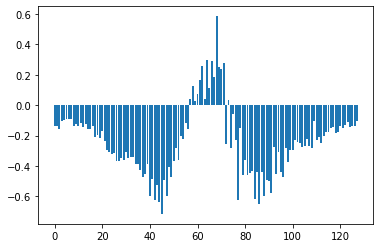

In [0]:
instrument_program = 53
plt.bar(norm_note_distributions_df.columns, norm_note_distributions_df.iloc[instrument_program].values)
plt.show()

In [0]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

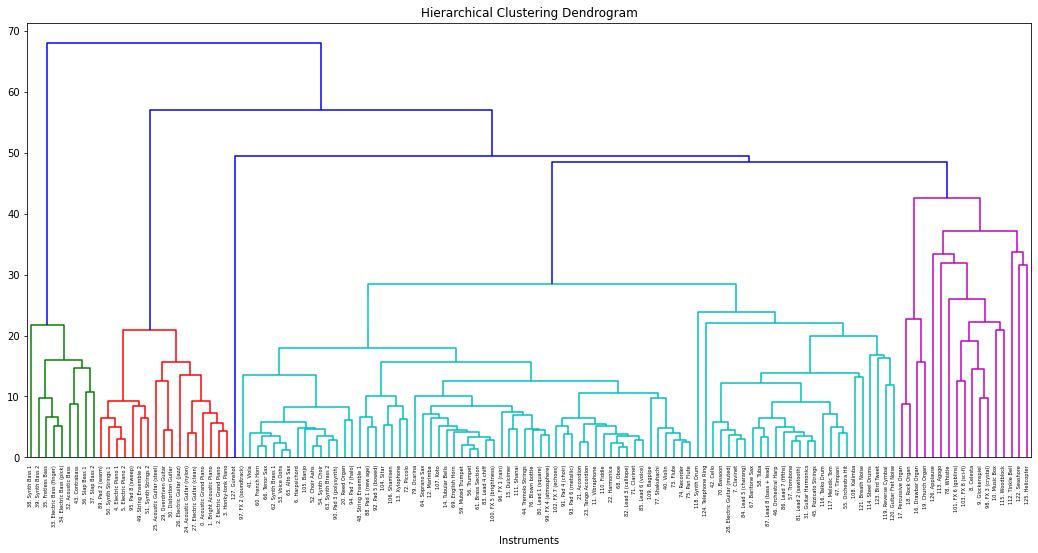

In [0]:
# DENDROGRAM WITH ALL INSTRUMENTS:

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(norm_note_distributions_df)
plt.figure(figsize=(18,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=128)
locs, labels = plt.xticks()
labels = [f"{text.get_text()}. {pretty_midi.program_to_instrument_name(int(text.get_text()))}" for text in labels]
plt.xticks(locs, labels)
plt.xlabel("Instruments")
plt.savefig("all_instruments_dendrogram.pdf")
plt.show()

In [0]:
def compare_instruments(inst_program_1, inst_program_2):
  instrument_1_name = pretty_midi.program_to_instrument_name(inst_program_1)
  instrument_2_name = pretty_midi.program_to_instrument_name(inst_program_2)
  songs_set_1 = set(instruments_count[inst_program_1])
  songs_set_2 = set(instruments_count[inst_program_2])
  intersection = songs_set_1.intersection(songs_set_2)
  print(f"Instrument {instrument_1_name} is present in {len(songs_set_1)} songs of the sample ({round(100*len(songs_set_1)/15513, 2)}% of sample)")
  print(f"Instrument {instrument_2_name} is present in {len(songs_set_2)} songs of the sample ({round(100*len(songs_set_2)/15513, 2)}% of sample)")
  print(f"Songs in common: {len(intersection)}")
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
  axes[0].bar(instruments_info_norm[inst_program_1].keys(), instruments_info_norm[inst_program_1].values())
  axes[1].bar(instruments_info_norm[inst_program_2].keys(), instruments_info_norm[inst_program_2].values())

Instrument Recorder is present in 151 songs of the sample (0.97% of sample)
Instrument Pan Flute is present in 679 songs of the sample (4.38% of sample)
Songs in common: 21


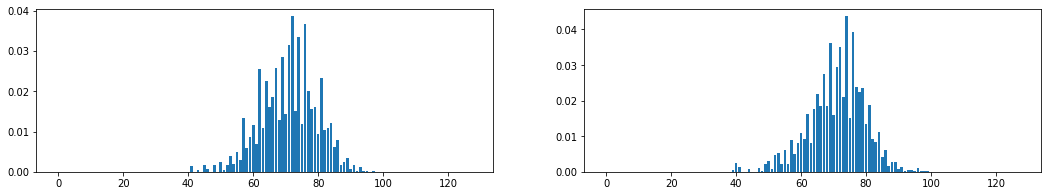

In [0]:
compare_instruments(74, 75)

In [0]:
outliers = {
19: "Church Organ",
113: "Agogo",
78: "Whistle",
17: "Percussive Organ",
18: "Rock Organ",
12: "Marimba",
79: "Ocarina",
13: "Xylophone",
16: "Drawbar Organ",
92: "Pad 5 (bowed)",
109: "Bagpipe",
48: "String Ensemble 1",
101: "FX 6 (goblins)",
122: "Seashore",
103: "FX 8 (sci-fi)",
9: "Glockenspiel",
115: "Woodblock",
127: "Gunshot",
97: "FX 2 (soundtrack)",
108: "Kalimba",
118: "Synth Drum",
114: "Steel Drums",
119: "Reverse Cymbal",
123: "Bird Tweet",
120: "Guitar Fret Noise",
124: "Telephone Ring",
55: "Orchestra Hit",
47: "Timpani",
8: "Celesta",
112: "Tinkle Bell",
125: "Helicopter",
126: "Applause"
}

In [0]:
important_instruments_df = norm_note_distributions_df.drop(norm_note_distributions_df.index[list(outliers.keys())])
new_index_to_old_index = {new_index: row[0] for new_index, row in enumerate(important_instruments_df.iterrows())}
important_instruments_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.115755,5.497221,-0.087873,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.129809,-0.110265,-0.143708,-0.122614,0.055312,-0.158172,-0.132695,-0.189875,-0.194453,-0.173014,-0.139679,-0.114002,-0.178005,-0.053564,-0.210446,0.012003,-0.122056,-0.129472,-0.012010,-0.039317,-0.036194,0.010442,0.297078,0.061945,0.254093,0.206619,0.330654,0.411064,0.499490,0.769061,...,-0.000699,0.047695,-0.000554,0.014573,-0.078969,-0.117140,-0.135357,-0.185710,-0.092184,-0.121519,-0.127446,-0.208758,-0.171357,-0.163790,-0.182603,-0.124498,-0.252316,-0.203400,-0.220697,-0.217218,-0.203744,-0.104918,-0.212809,-0.207978,-0.240462,-0.195994,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.137993,0.058233,-0.133806,-0.111553,-0.142915,-0.136911,-0.134646,0.553884
1,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.158172,-0.139910,-0.207677,-0.194453,-0.130095,-0.167582,-0.237016,0.088200,-0.161368,-0.080387,0.036016,0.063869,-0.019091,-0.046432,0.011451,-0.109912,0.088762,0.222207,-0.011466,0.292069,-0.052684,0.497118,0.443088,0.574630,1.141372,...,-0.001948,-0.084059,-0.022287,-0.013715,0.019132,-0.081729,-0.293513,-0.192907,-0.200969,-0.215755,-0.029794,-0.210893,-0.181653,-0.189474,-0.224566,-0.230402,0.015072,-0.023826,-0.225117,-0.246544,-0.267240,-0.050420,-0.231843,1.473731,-0.249106,-0.202186,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.090205,1.235599,0.129581,0.040541,0.024230,-0.136911,-0.128966,-0.106841
2,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.158172,-0.139910,-0.207677,-0.194453,-0.178980,-0.167582,-0.237016,-0.295932,-0.128939,-0.178318,-0.317417,-0.186692,-0.316960,-0.119425,-0.218603,-0.253140,-0.026384,-0.217895,0.023919,-0.136465,-0.219904,0.162229,0.021152,-0.035759,1.150437,...,-0.134612,-0.226392,-0.267331,-0.071260,-0.257767,-0.127902,-0.299552,-0.023680,0.405078,-0.231348,-0.311523,-0.232743,-0.061477,-0.227052,-0.240456,-0.241993,-0.272202,-0.261266,-0.225117,-0.255888,-0.273844,-0.104918,-0.219444,-0.207978,-0.249106,-0.202186,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.137993,-0.152228,-0.133806,-0.111553,-0.142915,-0.136911,-0.130351,-0.106841
3,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.158172,-0.139910,-0.207677,-0.194453,-0.216805,-0.167582,-0.237016,-0.295932,-0.310314,0.052012,-0.317417,0.043169,-0.253867,-0.103927,-0.158572,-0.034111,-0.300356,0.184017,0.240225,0.225068,-0.152733,-0.099665,0.568396,0.053775,-0.026597,...,-0.369327,-0.018488,-0.307548,-0.235701,-0.188989,-0.132811,0.095735,-0.223434,-0.306516,-0.274483,-0.299901,-0.032814,-0.293359,-0.227128,0.032245,-0.246449,-0.272202,-0.269904,-0.225117,-0.266063,-0.282011,-0.104918,-0.231843,-0.207978,-0.249106,-0.202186,-0.174577,-0.174169,-0.149146,-0.141614,-0.180125,-0.17654,-0.137993,-0.152228,-0.133806,-0.111553,-0.142915,-0.136911,-0.134646,-0.106841
4,-0.136868,-0.134019,-0.154394,-0.103535,-0.096907,-0.088388,-0.088388,-0.089694,-0.136258,-0.121459,-0.134571,-0.117139,-0.143708,-0.122614,-0.154141,-0.012784,-0.139910,-0.207677,-0.123762,-0.176187,0.212600,-0.237016,-0.295932,-0.202745,-0.046194,0.185345,0.243004,-0.199241,-0.226939,-0.259574,-0.205273,-0.212929,0.079017,-0.195960,-0.154197,-0.192161,0.006075,-0.188986,0.310741,0.419670,...,-0.167781,-0.081445,-0.247824,-0.090409,-0.142238,-0.249894,-0.152540,-0.434537,-0.439705,-0.282117,-0.312267,-0.281020,-0.296723,-0.134009,-0.240456,-0.208714,-0.272

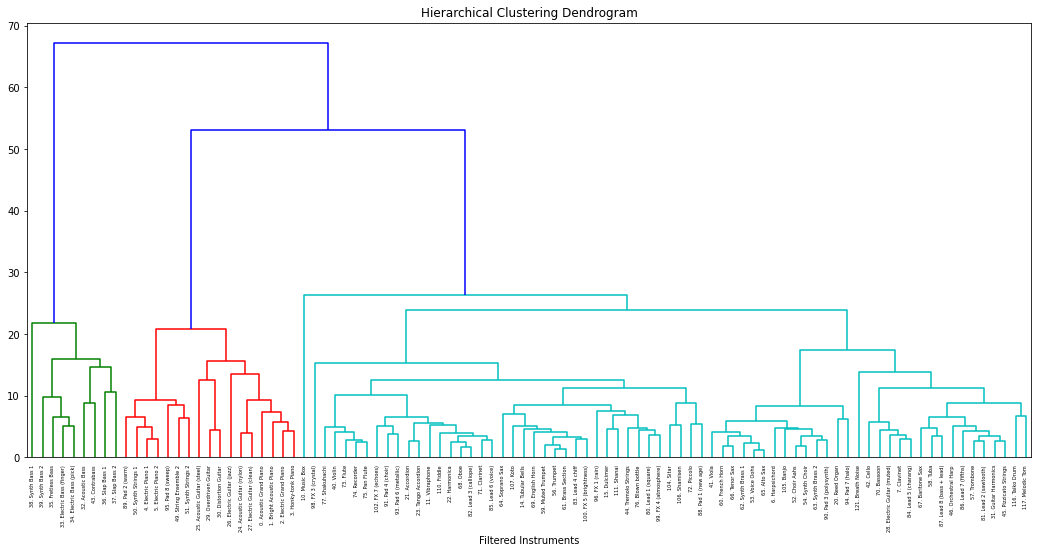

In [0]:
# DENDROGRAM REMOVING OUTLIERS INSTRUMENTS:

model = model.fit(important_instruments_df)
plt.figure(figsize=(18,8))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=128)
locs, labels = plt.xticks()
labels = [f"{new_index_to_old_index[int(text.get_text())]}. {pretty_midi.program_to_instrument_name(new_index_to_old_index[int(text.get_text())])}" for text in labels]
plt.xticks(locs, labels)
plt.xlabel("Filtered Instruments")
plt.savefig("filtered_instruments_dendrogram.pdf")
plt.show()

In [0]:
from collections import defaultdict
import os
import json
import pretty_midi

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path = 'gdrive/Shared drives/Digital Musicology 2020/data'
os.chdir(data_path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def merge_similar_instruments(pm_object, conversion_dict):
    # separate drum and non-drum instrument:
    present_instruments = defaultdict(bool)
    drum_instruments = list()
    not_drum_instruments = list()
    for instrument in pm_object.instruments:
        if instrument.is_drum:
            drum_instruments.append(instrument)
        else:
            present_instruments[conversion_dict[instrument.program]] = True
            not_drum_instruments.append(instrument)
    
    instruments_indexes = list(present_instruments.keys())
    if -1 in instruments_indexes:
      instruments_indexes.remove(-1)
    if len(instruments_indexes) < 3 or not drum_instruments:
      return False

    # merge all the notes of same instrument family:
    merged_instruments_notes = defaultdict(list)
    for instrument in not_drum_instruments:
        merged_instruments_notes[conversion_dict[instrument.program]].extend(instrument.notes)
  
    # sort the notes of each instrument family and create a new Instrument 
    # object with their new notes:
    pm_object.instruments = list()
    for program_number, notes_list in merged_instruments_notes.items():
        if program_number != -1:
            notes_list.sort(key=lambda note: note.start)
            new_instrument = pretty_midi.Instrument(program=program_number, is_drum=False)
            new_instrument.notes = notes_list
            pm_object.instruments.append(new_instrument)
    
    # create the drum instrument family and do the same process
    new_drum_instrument = pretty_midi.Instrument(program=0, is_drum=True)
    drums_notes = list()
    for drum_instrument in drum_instruments:
        drums_notes.extend(drum_instrument.notes)
    drums_notes.sort(key=lambda note: note.start)
    new_drum_instrument.notes = drums_notes
    pm_object.instruments.append(new_drum_instrument)
    return True

In [0]:
with open("genres_dict_merged.json") as json_file:
  genre_to_midi_paths = json.load(json_file)

In [0]:
pop_rock_set = set(genre_to_midi_paths["pop rock"])
ballad_set = set(genre_to_midi_paths["ballad"])
house_set = set(genre_to_midi_paths["house"])
unique_pop_rock_set = pop_rock_set - (ballad_set.union(house_set))
unique_ballad_set = ballad_set - (pop_rock_set.union(house_set))
#19849 (9914) --> 0.49
#14187 (7055) --> 0.49
#12654 (3217) --> 0.25

5377


In [0]:
with open("match_scores.json") as file:
    scores = json.load(file)

In [0]:
conversion_dict = {
    0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0,
    10: -1, 11: -1, 12: -1, 13: -1, 14: -1, 15: -1,
    16: 0, 17: 0, 18: 0, 19: 0, 20: 0,
    21: -1, 22: -1, 23: -1,
    24: 24, 25: 24, 26: 24, 27: 24, 28: 24, 29: 24, 30: 24, 31: 24,
    32: 32, 33: 32, 34: 32, 35: 32, 36: 32, 37: 32, 38: 32, 39: 32,
    40: -1, 41: -1, 42: -1, 43: -1, 44: -1, 45: -1, 46: -1, 47: -1, 48: -1, 49: -1, 50: -1, 51: -1, 52: -1, 53: -1, 54: -1, 55: -1, 56: -1, 57: -1, 58: -1, 59: -1, 60: -1, 61: -1, 62: -1, 63: -1, 64: -1, 65: -1, 66: -1, 67: -1, 68: -1, 69: -1, 70: -1, 71: -1, 72: -1, 73: -1, 74: -1, 75: -1, 76: -1, 77: -1, 78: -1, 79: -1, 80: -1, 81: -1, 82: -1, 83: -1, 84: -1, 85: -1, 86: -1, 87: -1, 88: -1, 89: -1, 90: -1, 91: -1, 92: -1, 93: -1, 94: -1, 95: -1, 96: -1, 97: -1, 98: -1, 99: -1, 100: -1, 101: -1, 102: -1, 103: -1, 104: -1, 105: -1, 106: -1, 107: -1, 108: -1, 109: -1, 110: -1, 111: -1, 112: -1, 113: -1, 114: -1, 115: -1, 116: -1, 117: -1, 118: -1, 119: -1, 120: -1, 121: -1, 122: -1, 123: -1, 124: -1, 125: -1, 126: -1, 127: -1
}

In [0]:
i = 0
for genre, midi_dir_list in genre_to_midi_paths.items():
  files_count = 0
  errors_count = 0
  for midi_dir in midi_dir_list:
    final_midi_path_list = list(scores[midi_dir[6:]].keys())
    for final_midi_path in final_midi_path_list:
      if not i%100:
        print(i)
      files_count += 1
      try:
        pm_object = pretty_midi.PrettyMIDI(f"lmd_aligned/{midi_dir}/{final_midi_path}.mid")
        if merge_similar_instruments(pm_object, conversion_dict):
          os.chdir(f"modified_midis/{genre.replace(' ', '')}")
          pm_object.write(f"{midi_dir[6:]}-{final_midi_path}.mid")
          os.chdir("../../")
      except:
        errors_count += 1
      i += 1
  print(f"Genre {genre} had {errors_count} out of {files_count}")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [0]:
poprock_set = set(os.listdir("modified_midis/poprock"))
ballad_set = set(os.listdir("modified_midis/ballad"))
house_set = set(os.listdir("modified_midis/house"))

3217

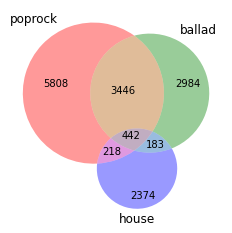

In [0]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt


venn3([poprock_set, ballad_set, house_set], ('poprock', 'ballad', 'house'))
plt.savefig("intersection_of_subsets.pdf")
plt.show()

**Encoding part:**

In [0]:
def pm_to_array(notes):
    length = len(notes)
    notesArr =  pd.DataFrame([['']*4]*length)
    for i in range(length):
        string = str(notes[i])
        s1, s2, s3, s4, s5 = string.split('=')
        v1, t= s2.split(',')
        v2,t= s3.split(',')
        v3, t = s4.split(',')
        s5 = s5[:-1]
        notesArr[0][i] = v1
        notesArr[1][i] = v2
        notesArr[2][i] = v3
        notesArr[3][i] = s5
    return notesArr

# **The model**

**Explanation of method - RNN:**

As previously discussed out choice of an RNN network was well fitted to the task as we've been able ot achieve relatively low loss 
across mutiple genres (only one present in this notebook).
We are currently using sparse categorical cross entropy as our loss function and setting the model parameters to 1024 rnn units and 256 nodes in the embedding layer

**Changes from previous:**

We strongly adjusted the encoding method from the previous iteration to include more seperation of notes by inception time (8 instead of 4 buckets per second) and more notes at each time step 
to account for genres like house that have many overlapping notes. However, this makes the note representation quite sparse which is an issue as it artificially inflated loss because so many values are zero.
We are looing in to adjusting the loss function and test batch to correct this, and looking into changing the encoding a bit as well. 

**Discussion of Results:**

We are still training many of the models (they take quite a while to train and it also was slow to pass the note data through our pipelines as well). However our preliminary findings indicate there is 
not a susbtantial difference in the ability to learn the genres based on their loss rates. This coould change as we modify the loss/ encoding as described above, but as a preliminary finding is 
a solid answer in regards to our research question. We will procede to analyze if there is any difference in the type of features that are learned even if the loss rate is similar. 

In [0]:
import tensorflow as tf 
import numpy as np
import os
import pandas as pd
import time
from os import listdir
import functools
import pickle
import math
from IPython import display as ipythondisplay
from tqdm import tqdm

In [0]:
import subprocess
import regex as re

import matplotlib.pyplot as plt
from IPython import display as ipythondisplay


from IPython.display import Audio
from string import Formatter





def display_model(model):
  tf.keras.utils.plot_model(model,
             to_file='tmp.png',
             show_shapes=True)
  return ipythondisplay.Image('tmp.png')


def plot_sample(x,y,vae):
    plt.figure(figsize=(2,1))
    plt.subplot(1, 2, 1)

    idx = np.where(y==1)[0][0]
    plt.imshow(x[idx])
    plt.grid(False)

    plt.subplot(1, 2, 2)
    _, _, _, recon = vae(x)
    recon = np.clip(recon, 0, 1)
    plt.imshow(recon[idx])
    plt.grid(False)

    plt.show()



class LossHistory:
  def __init__(self, smoothing_factor=0.0):
    self.alpha = smoothing_factor
    self.loss = []
  def append(self, value):
    self.loss.append( self.alpha*self.loss[-1] + (1-self.alpha)*value if len(self.loss)>0 else value )
  def get(self):
    return self.loss

class PeriodicPlotter:
  def __init__(self, sec, xlabel='', ylabel='', scale=None):

    self.xlabel = xlabel
    self.ylabel = ylabel
    self.sec = sec
    self.scale = scale

    self.tic = time.time()

  def plot(self, data):
    if time.time() - self.tic > self.sec:
      plt.cla()

      if self.scale is None:
        plt.plot(data)
      elif self.scale == 'semilogx':
        plt.semilogx(data)
      elif self.scale == 'semilogy':
        plt.semilogy(data)
      elif self.scale == 'loglog':
        plt.loglog(data)
      else:
        raise ValueError("unrecognized parameter scale {}".format(self.scale))

      plt.xlabel(self.xlabel); plt.ylabel(self.ylabel)
      ipythondisplay.clear_output(wait=True)
      ipythondisplay.display(plt.gcf())

      self.tic = time.time()
        
cwd = os.getcwd()

def load_training_data():
    with open(os.path.join(cwd, "data", "irish.abc"), "r") as f:
        text = f.read()
    songs = extract_song_snippet(text)
    return songs

def extract_song_snippet(text):
    pattern = '\n\n(.*?)\n\n'
    search_results = re.findall(pattern, text, overlapped=True, flags=re.DOTALL)
    songs = [song for song in search_results]
    print("Found {} songs in text".format(len(songs)))
    return songs

def save_song_to_abc(song, filename="tmp"):
    save_name = "{}.abc".format(filename)
    print(save_name)
    with open(save_name, "w") as f:
        f.write(song)
    return filename

def abc2wav(abc_file):
    path_to_tool = os.path.join(cwd, 'introtodeeplearning_labs/mitdeeplearning/bin', 'abc2wav')
    cmd = "{} {}".format(path_to_tool, abc_file)
    print(cmd)
    return os.system(cmd)

def play_wav(wav_file):
    return Audio(wav_file)

def play_song(song):
    basename = save_song_to_abc(song)
    ret = abc2wav(basename+'.abc')
    print(ret)
   # if ret == 0: #did not suceed
        #return play_wav(basename+'.wav')
    return None

def play_generated_song(generated_text):
    songs = extract_song_snippet(generated_text)
    print(songs)
    if len(songs) == 0:
        print("No valid songs found in generated text. Try training the \
            model longer or increasing the amount of generated music to \
            ensure complete songs are generated!")

    for song in songs:
        play_song(song)
    print("None of the songs were valid, try training longer to improve \
        syntax.")

def test_batch_func_types(func, args):
    ret = func(*args)
    assert len(ret) == 2, "[FAIL] get_batch must return two arguments (input and label)"
    assert type(ret[0]) == np.ndarray, "[FAIL] test_batch_func_types: x is not np.array"
    assert type(ret[1]) == np.ndarray, "[FAIL] test_batch_func_types: y is not np.array"
    print("[PASS] test_batch_func_types")
    return True

def test_batch_func_shapes(func, args):
    dataset, seq_length, batch_size = args
    x, y = func(*args)
    correct = (batch_size, seq_length)
    assert x.shape == correct, "[FAIL] test_batch_func_shapes: x {} is not correct shape {}".format(x.shape, correct)
    assert y.shape == correct, "[FAIL] test_batch_func_shapes: y {} is not correct shape {}".format(y.shape, correct)
    print("[PASS] test_batch_func_shapes")
    return True

def test_batch_func_next_step(func, args):
    x, y = func(*args)
    assert (x[:,1:] == y[:,:-1]).all(), "[FAIL] test_batch_func_next_step: x_{t} must equal y_{t-1} for all t"
    print("[PASS] test_batch_func_next_step")
    return True

def test_custom_dense_layer_output(y):
    true_y = np.array([[0.2697859,  0.45750418, 0.66536945]],dtype='float32')
    assert tf.shape(y).numpy().tolist() == list(true_y.shape), "[FAIL] output is of incorrect shape. expected {} but got {}".format(true_y.shape, y.numpy().shape)
    np.testing.assert_almost_equal(y.numpy(), true_y, decimal=7, err_msg="[FAIL] output is of incorrect value. expected {} but got {}".format(y.numpy(), true_y), verbose=True)
    print("[PASS] test_custom_dense_layer_output")
    return True

In [0]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
   
  model = tf.keras.Sequential([
   
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    
   LSTM(rnn_units), 
    
    tf.keras.layers.Dense(vocab_size)
    
  ])

  return model

In [0]:
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  return loss

In [0]:
def encode_notes_full(notesArr):
    size = math.ceil(notesArr[-1:][1])
    sizeF = size*8
    mod = sizeF%120
    pad = 0
    if(mod != 0):
         pad = 120 - mod
    encodeNotes =  pd.DataFrame([[0.0]*30]*(sizeF+pad))
    length = len(notesArr)
    count = 0
    partInt=0
    for i in range(length):
        start = notesArr[0][i]
        count = 0
        end = notesArr[1][i]
        dur = float(end) - float(start)
        startInt = int(float(start))
        part = float(start) - startInt
        index = (startInt)*8
        if(part<=0.125):
            partInt = 0
        elif(0.125<part<=0.25):
            partInt = 1
        elif(0.25<part<=0.375):
            partInt = 2
        elif(0.375<part<=0.5):
            partInt = 3
        elif(0.5<part<=0.625):
            partInt = 4
        elif(0.625<part<=0.75):
            partInt = 5
        elif(0.75<part<=0.875):
            partInt = 6
        elif(0.875<part<=1.0):
            partInt = 7
        #print(partInt)
        for j in range(29):
            if(encodeNotes[j][index + partInt]==0.0 and encodeNotes[j+1][index + partInt]==0.0 and encodeNotes[j+2][index + partInt]==0.0):
                #print('here')
                encodeNotes[j][index + partInt] = dur
                encodeNotes[j+1][index + partInt] = notesArr[2][i]
                encodeNotes[j+2][index + partInt] = notesArr[3][i]
                break
    return encodeNotes
            

In [0]:
infile = open('/content/drive/My Drive/MusicData/balladArr.pkl','rb')
ballad = pickle.load(infile)
infile.close()

In [0]:
modelF = build_model(200, embedding_dim=256, rnn_units=1024, batch_size=120)

In [0]:
def get_encoded_song( songNum, instrument):
    drums = encode_notes_full(ballad[0][songNum])
    piano = encode_notes_full(ballad[1][songNum])
    guitar = encode_notes_full(ballad[2][songNum])
    bass = encode_notes_full(ballad[3][songNum])
    fullSong = pd.concat([drums, piano, guitar, bass], axis=1, sort=False)
    if(instrument=='drums'):
        zero =  pd.DataFrame([[0.0]*30]*(len(drums)))
        insSong = pd.concat([drums, zero, zero, zero], axis=1, sort=False)
    if(instrument=='piano'):
        zero =  pd.DataFrame([[0.0]*30]*(len(piano)))
        insSong = pd.concat([zero, piano, zero, zero], axis=1, sort=False)
    if(instrument=='guitar'):
        zero =  pd.DataFrame([[0.0]*30]*(len(guitar)))
        insSong = pd.concat([zero, zero, guitar, zero], axis=1, sort=False)
    if(instrument=='bass'):
        zero =  pd.DataFrame([[0.0]*30]*(len(bass)))
        insSong = pd.concat([zero, zero, zero, bass], axis=1, sort=False)
    fullSong.fillna(0.0, inplace=True)
    insSong.fillna(0.0, inplace=True)
    return fullSong, insSong
    

In [0]:
def get_batchF(encodedNotes, encodedIns1, iteration):

    idx = int(iteration * 120)
    input_batch = encodedNotes[idx:(idx+120)].values

    output_batch = encodedIns1[(idx+120):(idx+240)].values
    output_batch[output_batch > 200] = 200
    output_batch[output_batch < 0] = 0
    input_batch[input_batch > 200] = 200
    input_batch[input_batch < 0] = 0
    return input_batch, output_batch

In [0]:
num_training_iterations = 2*len(ballad)
learning_rate = 5e-3 
#genreCleaned= house
instrument = 'piano'
totalSongs = len(ballad)

checkpoint_dir = '/content/drive/My Drive/MusicData/' 
checkpoint_prefix = os.path.join(checkpoint_dir, "balladPiano")

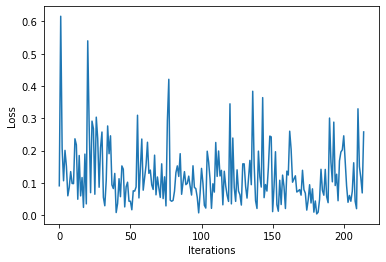

  3%|▎         | 215/6426 [1:23:40<59:15:08, 34.34s/it]

0


In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate)

@tf.function
def train_step(x, y): 

  with tf.GradientTape() as tape:
  
    y_hat = modelF(x) 
    
    loss = compute_loss(y, y_hat) 

 
  grads = tape.gradient(loss, modelF.trainable_variables) 
  
  optimizer.apply_gradients(zip(grads, modelF.trainable_variables))
  return loss

history = []
plotter = PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() 
for iter in tqdm(range(num_training_iterations)):
    if (iter>totalSongs):
        songNum = iter%totalSongs
    else: 
        songNum = iter
    
    song, ins = get_encoded_song( iter, instrument)
    
    for j in range(int(min((len(song)/120)-1,int((len(ins)/120)-1)))):
        print(j)
        x_batch, y_batch = get_batchF(song, ins, j)
        loss = train_step(x_batch, y_batch)
        
    history.append(loss.numpy().mean())
    plotter.plot(history)

    if(iter % 100 == 0):     
            print('Saved')
            modelF.save_weights(checkpoint_prefix)
    

modelF.save_weights(checkpoint_prefix)